In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-05-29 00:11:51--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  33.5MB/s    in 51s     

2024-05-29 00:12:42 (26.2 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


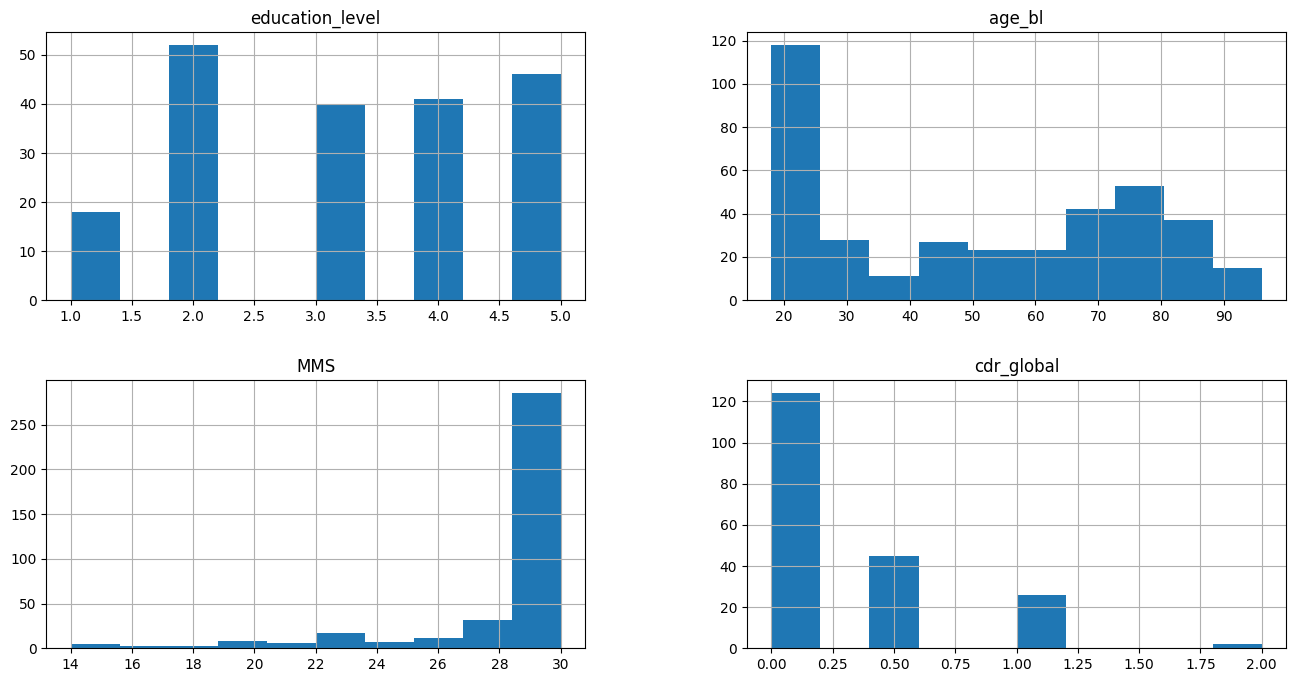

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
# To complete
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.pool1 = PadMaxPool3d(2, 2)  # Assume PadMaxPool3d is defined elsewhere

        self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool2 = PadMaxPool3d(2, 2)

        self.conv3 = nn.Conv3d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(32)
        self.pool3 = PadMaxPool3d(2, 2)

        self.conv4 = nn.Conv3d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm3d(64)
        self.pool4 = PadMaxPool3d(2, 2)

        self.conv5 = nn.Conv3d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm3d(128)
        self.pool5 = PadMaxPool3d(2, 2)

        self.conv6 = nn.Conv3d(128, 256, 3, padding=1)  # New layer
        self.bn6 = nn.BatchNorm3d(256)
        self.pool6 = PadMaxPool3d(2, 2)  # New layer

        self.conv7 = nn.Conv3d(256, 512, 3, padding=1)  # New layer
        self.bn7 = nn.BatchNorm3d(512)
        self.pool7 = PadMaxPool3d(2, 2)  # New layer

        # Expanded linear section
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),  # Adjusted for new conv layer output size
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        x = F.leaky_relu(self.bn6(self.conv6(x)))  # Processing new layer
        x = self.pool6(x)

        x = F.leaky_relu(self.bn7(self.conv7(x)))  # Processing new layer
        x = self.pool7(x)

        x = x.view(x.size(0), -1)  # Flatten the output for the linear layers
        x = self.linear(x)
        return x

In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.6911, Val loss = 13.0506
Epoch 1: Train loss = 1.5729, Val loss = 10.7807
Epoch 2: Train loss = 1.6716, Val loss = 12.2792
Epoch 3: Train loss = 1.4758, Val loss = 10.5036
Epoch 4: Train loss = 1.4065, Val loss = 7.6903
Epoch 5: Train loss = 1.2762, Val loss = 17.5752
Epoch 6: Train loss = 1.4473, Val loss = 9.2973
Epoch 7: Train loss = 1.5755, Val loss = 9.6661
Epoch 8: Train loss = 1.4092, Val loss = 15.5892
Epoch 9: Train loss = 1.4581, Val loss = 16.8483
Epoch 10: Train loss = 1.2941, Val loss = 11.0616
Epoch 11: Train loss = 1.3651, Val loss = 8.6990
Epoch 12: Train loss = 1.4035, Val loss = 9.5709
Epoch 13: Train loss = 1.5314, Val loss = 10.1700
Epoch 14: Train loss = 1.3035, Val loss = 11.4265
Epoch 15: Train loss = 1.3152, Val loss = 15.4015
Epoch 16: Train loss = 1.2413, Val loss = 10.5206
Epoch 17: Train loss = 1.4101, Val loss = 8.4741
Epoch 18: Train loss = 1.4243, Val loss = 9.8126
Epoch 19: Train loss = 1.4059, Val loss = 17.0093
Epoch 20: Train l

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0] Type: int64
Confusion Matrix:
 [[62  0]
 [15  0]]


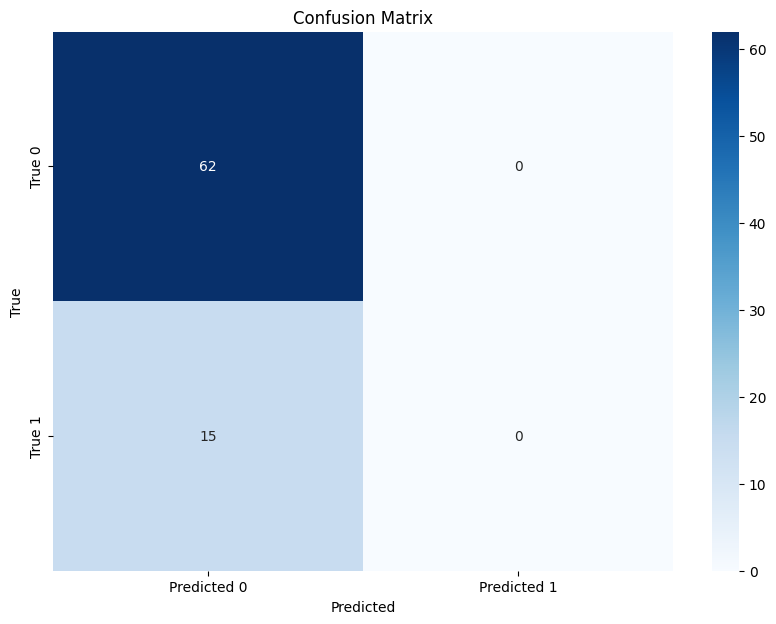

Learning Rate: 0.001 - Validation Accuracy: 0.8051948051948052


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.7866, Val loss = 14.6044
Epoch 1: Train loss = 1.4509, Val loss = 14.7338
Epoch 2: Train loss = 1.2917, Val loss = 10.1403
Epoch 3: Train loss = 1.4372, Val loss = 13.0395
Epoch 4: Train loss = 1.2497, Val loss = 12.6160
Epoch 5: Train loss = 1.1602, Val loss = 10.6202
Epoch 6: Train loss = 1.1463, Val loss = 24.8646
Epoch 7: Train loss = 1.0881, Val loss = 10.8954
Epoch 8: Train loss = 1.4360, Val loss = 11.2215
Epoch 9: Train loss = 1.4177, Val loss = 13.4045
Epoch 10: Train loss = 1.2744, Val loss = 7.2708
Epoch 11: Train loss = 1.1411, Val loss = 8.2234
Epoch 12: Train loss = 1.0489, Val loss = 11.5513
Epoch 13: Train loss = 1.2005, Val loss = 9.2024
Epoch 14: Train loss = 0.8559, Val loss = 8.6703
Epoch 15: Train loss = 1.0019, Val loss = 11.6068
Epoch 16: Train loss = 1.0899, Val loss = 62.2159
Epoch 17: Train loss = 1.0045, Val loss = 13.3069
Epoch 18: Train loss = 0.9946, Val loss = 12.7476
Epoch 19: Train loss = 0.8951, Val loss = 19.5098
Epoch 20: Trai

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 4 11]]


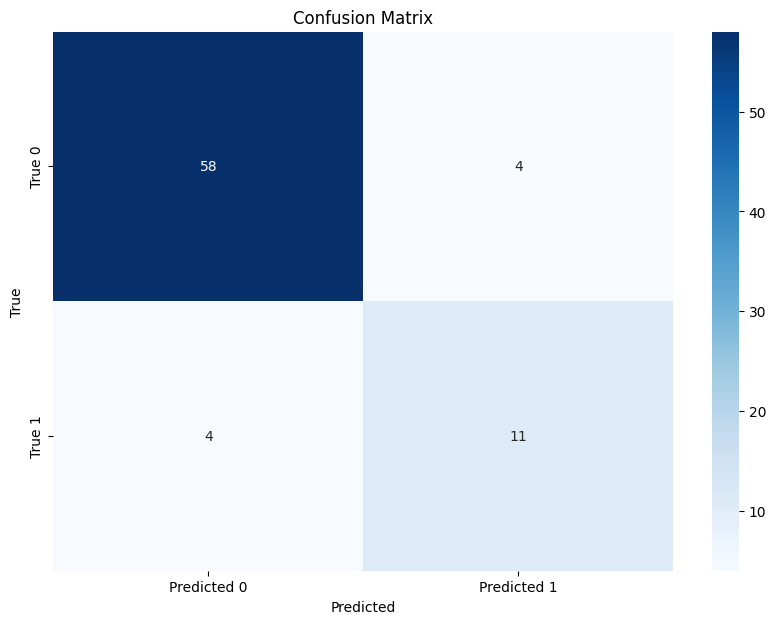

Learning Rate: 0.0005 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0339, Val loss = 8.9316
Epoch 1: Train loss = 1.2970, Val loss = 8.5072
Epoch 2: Train loss = 1.1585, Val loss = 8.0223
Epoch 3: Train loss = 0.7911, Val loss = 12.3781
Epoch 4: Train loss = 0.6520, Val loss = 7.2990
Epoch 5: Train loss = 0.7214, Val loss = 13.3826
Epoch 6: Train loss = 0.5367, Val loss = 9.3185
Epoch 7: Train loss = 0.6118, Val loss = 44.1437
Epoch 8: Train loss = 0.6524, Val loss = 17.5083
Epoch 9: Train loss = 0.6412, Val loss = 12.3373
Epoch 10: Train loss = 0.6279, Val loss = 9.1439
Epoch 11: Train loss = 0.2722, Val loss = 8.1004
Epoch 12: Train loss = 0.5388, Val loss = 70.8656
Epoch 13: Train loss = 0.6709, Val loss = 16.0971
Epoch 14: Train loss = 0.3645, Val loss = 28.9623
Epoch 15: Train loss = 0.2188, Val loss = 31.4340
Epoch 16: Train loss = 0.2668, Val loss = 11.7922
Epoch 17: Train loss = 0.3967, Val loss = 29.5358
Epoch 18: Train loss = 0.4571, Val loss = 9.1626
Epoch 19: Train loss = 0.2584, Val loss = 29.4621
Epoch 20: Train lo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[56  6]
 [ 2 13]]


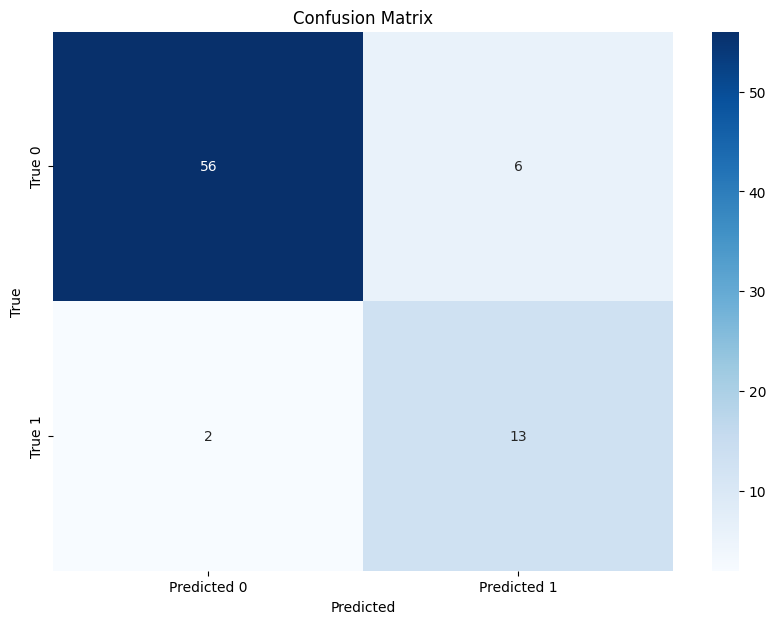

Learning Rate: 0.0001 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.2415, Val loss = 11.7389
Epoch 1: Train loss = 1.5042, Val loss = 9.3069
Epoch 2: Train loss = 1.1879, Val loss = 9.1912
Epoch 3: Train loss = 1.0855, Val loss = 8.7003
Epoch 4: Train loss = 0.9750, Val loss = 8.6934
Epoch 5: Train loss = 0.8414, Val loss = 7.1096
Epoch 6: Train loss = 0.5794, Val loss = 7.6140
Epoch 7: Train loss = 0.4916, Val loss = 7.4306
Epoch 8: Train loss = 0.4065, Val loss = 18.4765
Epoch 9: Train loss = 0.4510, Val loss = 9.7402
Epoch 10: Train loss = 0.3777, Val loss = 9.8470
Epoch 11: Train loss = 0.5195, Val loss = 14.8313
Epoch 12: Train loss = 0.4489, Val loss = 16.3653
Epoch 13: Train loss = 0.1782, Val loss = 24.8013
Epoch 14: Train loss = 0.1820, Val loss = 8.9497
Epoch 15: Train loss = 0.1382, Val loss = 17.3231
Epoch 16: Train loss = 0.3106, Val loss = 11.2684
Epoch 17: Train loss = 0.3390, Val loss = 13.7543
Epoch 18: Train loss = 0.2741, Val loss = 13.8613
Epoch 19: Train loss = 0.1532, Val loss = 11.3103
Epoch 20: Train loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[56  6]
 [ 5 10]]


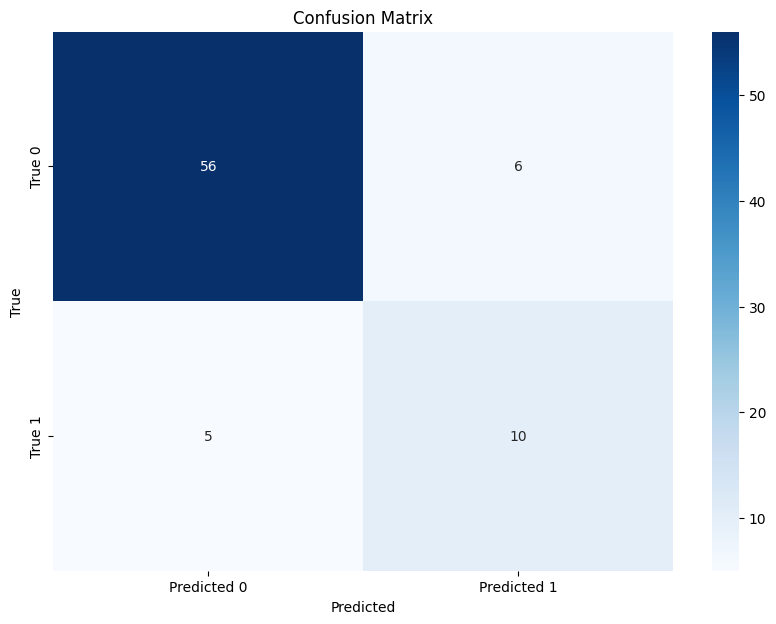

Learning Rate: 5e-05 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.4887, Val loss = 15.9559
Epoch 1: Train loss = 2.3880, Val loss = 15.3475
Epoch 2: Train loss = 2.2779, Val loss = 14.6374
Epoch 3: Train loss = 2.1224, Val loss = 13.6904
Epoch 4: Train loss = 1.9763, Val loss = 12.8805
Epoch 5: Train loss = 1.7592, Val loss = 11.2963
Epoch 6: Train loss = 1.6691, Val loss = 10.2833
Epoch 7: Train loss = 1.4554, Val loss = 9.8342
Epoch 8: Train loss = 1.3420, Val loss = 9.5677
Epoch 9: Train loss = 1.2908, Val loss = 8.8404
Epoch 10: Train loss = 1.2504, Val loss = 8.6321
Epoch 11: Train loss = 1.2231, Val loss = 8.8512
Epoch 12: Train loss = 1.1070, Val loss = 8.3626
Epoch 13: Train loss = 0.9998, Val loss = 8.0414
Epoch 14: Train loss = 0.9646, Val loss = 8.1569
Epoch 15: Train loss = 0.9231, Val loss = 8.2624
Epoch 16: Train loss = 0.8513, Val loss = 8.0563
Epoch 17: Train loss = 0.8101, Val loss = 8.1922
Epoch 18: Train loss = 0.7558, Val loss = 7.8962
Epoch 19: Train loss = 0.6354, Val loss = 8.1377
Epoch 20: Train loss = 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 6  9]]


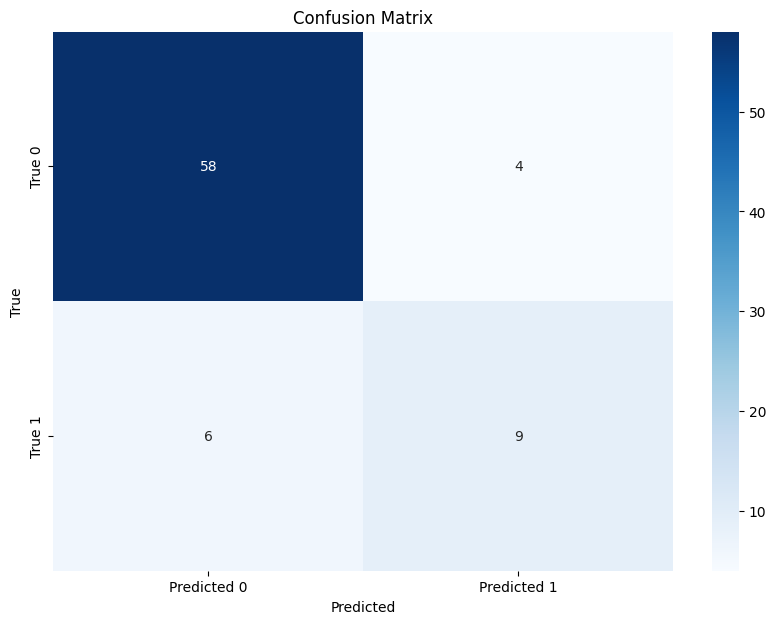

Learning Rate: 1e-05 - Validation Accuracy: 0.8701298701298701


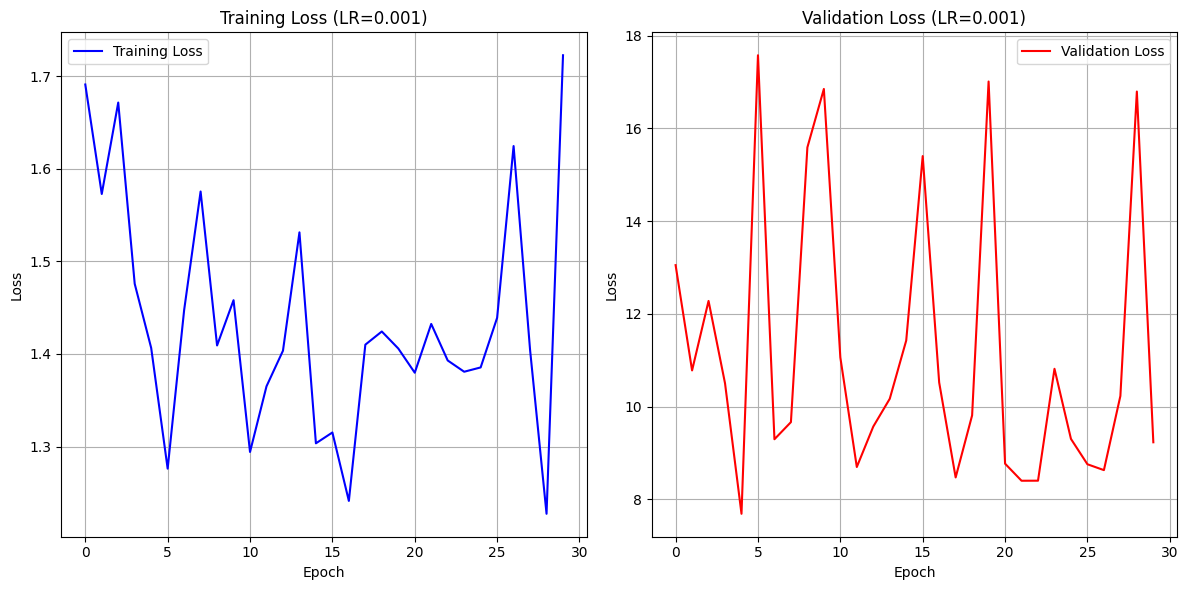

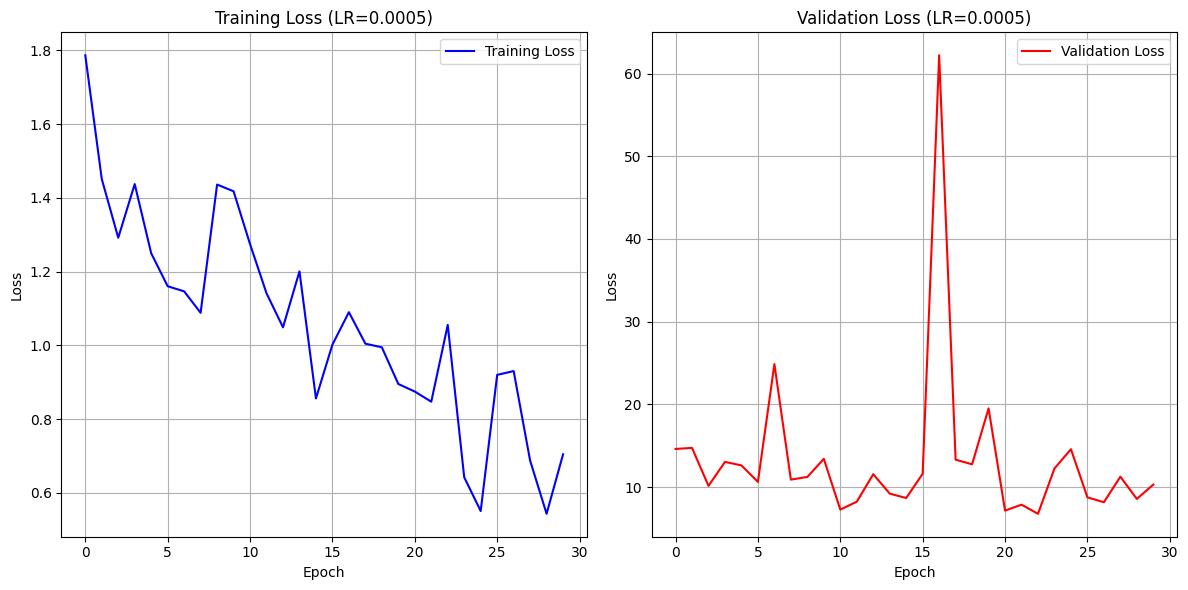

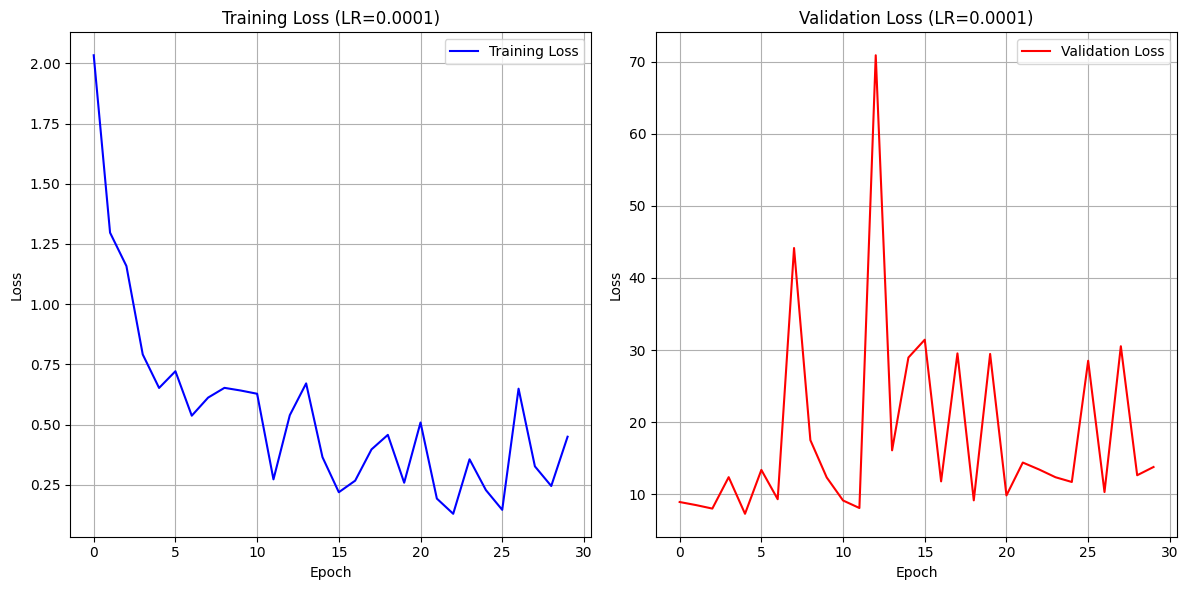

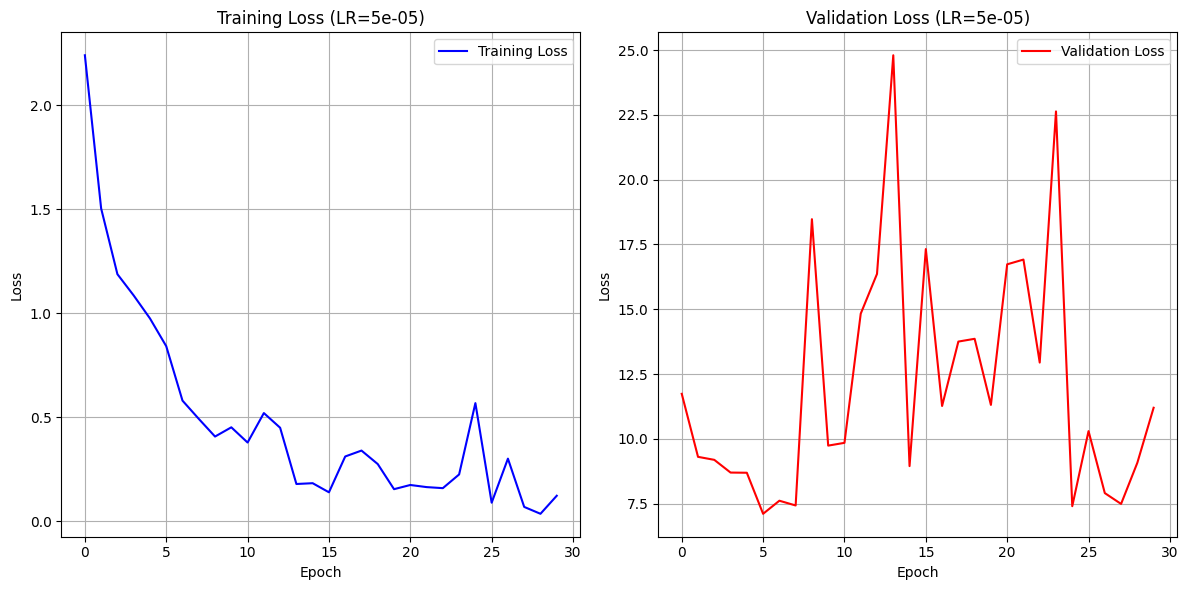

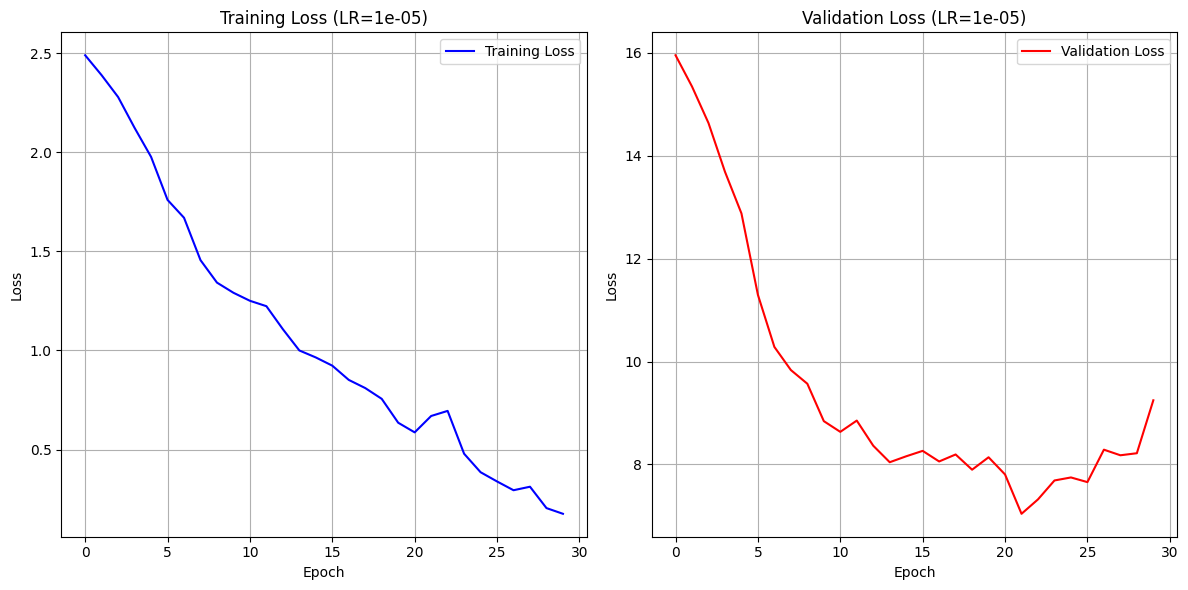

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomNetwork().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)